In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
import joblib

/home/malladi/projects/resume_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


# === Load and clean data ===
df = pd.read_excel("/home/malladi/projects/resume_project/clas.xlsx")

roles = [
    "Backend Software Engineer", "Frontend Developer (React)", "DevOps Engineer",
    "QA Automation Engineer", "Data Analyst", "Machine Learning Engineer",
    "Cloud Engineer", "Security Engineer", "Software Product Manager", "Full Stack Developer"
]

print("Original rows:", len(df))
df = df[df['role'].notnull()]
df = df[df['role'].isin(roles)]
df = df.drop_duplicates(subset='resume_str')
df = df[df['resume_str'].str.len() > 50]
print("Cleaned rows:", len(df))

# # === Oversample Full Stack Developer ===
# fs_mask = df['role'] == 'Full Stack Developer'
# df_fs = df[fs_mask]
# df_upsampled = resample(df_fs, replace=True, n_samples=30, random_state=42)
# df = pd.concat([df, df_upsampled])

# === Encode labels ===
le = LabelEncoder()
df['label'] = le.fit_transform(df['role'])


Original rows: 209
Cleaned rows: 189


In [3]:


# === Embeddings ===
print("Generating embeddings with sentence-t5-large ...")
embedder = SentenceTransformer('sentence-t5-large')
X = embedder.encode(df['resume_str'].tolist(), show_progress_bar=True)
y = df['label']

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



Generating embeddings with sentence-t5-large ...


Batches: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


/home/malladi/projects/resume_project/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [09:05:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training XGBoost ...

Classification Report (XGBoost):
                            precision    recall  f1-score   support

 Backend Software Engineer       0.50      0.25      0.33         4
            Cloud Engineer       0.40      0.50      0.44         4
              Data Analyst       0.75      0.75      0.75         4
           DevOps Engineer       0.75      0.75      0.75         4
Frontend Developer (React)       0.40      0.50      0.44         4
      Full Stack Developer       0.67      0.80      0.73        10
 Machine Learning Engineer       0.57      1.00      0.73         4
    QA Automation Engineer       1.00      0.25      0.40         4
         Security Engineer       1.00      0.33      0.50         3
  Software Product Manager       0.33      0.33      0.33         3

                  accuracy                           0.59        44
                 macro avg       0.64      0.55      0.54        44
              weighted avg       0.64      0.59      0.57 

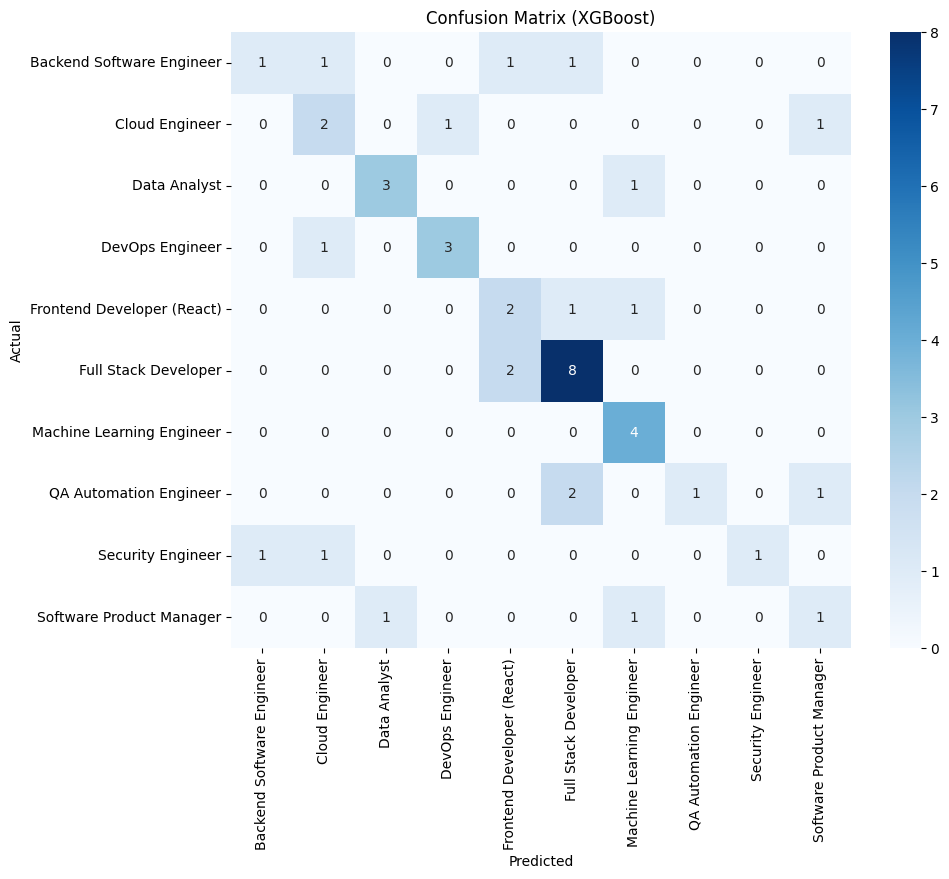

In [4]:
# === Train classifier ===
print("\nTraining XGBoost ...")
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluate ===
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.show()




In [5]:
# === Save model + encoder ===
joblib.dump(clf, "xgb_resume_classifier.pkl")
joblib.dump(le, "label_encoder.pkl")
print("Model and label encoder saved.")



Model and label encoder saved.


In [6]:
# === Predict on new resumes ===
def predict_role(resumes):
    embed = embedder.encode(resumes, show_progress_bar=False)
    pred_labels = clf.predict(embed)
    pred_roles = le.inverse_transform(pred_labels)
    for r, p in zip(resumes, pred_roles):
        print(f"Predicted Role: {p}\nResume Snippet: {r[:100]}...\n")

# === Example usage ===
new_resumes = [
    "Experienced backend developer with Django, Flask, and PostgreSQL expertise, deployed apps on AWS.",
    "Cloud engineer with hands-on experience in Azure, GCP, and Kubernetes cluster management."
]
predict_role(new_resumes)

Predicted Role: Full Stack Developer
Resume Snippet: Experienced backend developer with Django, Flask, and PostgreSQL expertise, deployed apps on AWS....

Predicted Role: Cloud Engineer
Resume Snippet: Cloud engineer with hands-on experience in Azure, GCP, and Kubernetes cluster management....

